In [1]:
#____________________________________________________________________________________
#______________	 PYTHON CODE ON ID HELIUM DBD   (7-11-2017)  _____________________
#______________				 SAURAV GAUTAM		 _______________________________
#____________________________________________________________________________________
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy.sparse.linalg as la
import scipy.sparse as sparse
import time as tm

####==============   POISSON MATRIX USED TO SOLVE THE POISSON'S EQUATION IMPLICTLY   ========================
#============================================================================================================
def SparseLaplacianOperator(nx,k1=-1,k2=0,k3=1):
	#this function simply creates a tridiagonal matrix with -2 on the main diagonal and
	#1 on the diagonal below and above the main diagonal. nx is the size of the matrix
	d1=np.zeros((nx),float)
	d2=np.ones((nx),float)
	d3=np.zeros((nx),float)
	d1[:-2]=1; d2[1:-1]=-2;d3[2:]=1
	return (sparse.dia_matrix(([d1,d2,d3],[k1,k2,k3]),shape=(nx,nx)).tocsc() ) 
#------------------------------------------------------------------------------------------------------------


#SPARSE TRIDIAGONAL MATRIX USED TO SOLVE THE DIFFUSION EQUATION IMPLICTLY====================================
#============================================================================================================
def SparseDiffusionOperator(numberdensity,dif,dx,dt,k1=-1,k2=0,k3=1):
	nx=dif.size
	d1=np.zeros((nx),float)  #diagonal below main diagonal
	d2=np.ones((nx),float)   #main diagonal
	d3=np.zeros((nx),float)  #diagonal above main diagonal
	d1[:-2]=(dt/(4*dx*dx))*(dif[2:]-dif[:-2]-4*dif[1:-1])
	d2[1:-1]=(1+2*dt*dif[1:-1]/(dx**2))
	d3[2:]=(dt/(4*dx*dx))*(-dif[2:]+dif[:-2]-4*dif[1:-1])
	return (la.spsolve((sparse.dia_matrix(([d1,d2,d3],[k1,k2,k3]),shape=(nx,nx)).tocsc()),numberdensity))
#------------------------------------------------------------------------------------------------------------

#INTERPOLATION FORMULA ======================================================================================
def Interpolation(fieldvalue,inputdat, interval, maximumvalue,error):
	#the transport, and reaction coefficients come from the table that has limited values. 
	#this function takes those values and uses linear approximation to fit the data for the
	#actual values that are obtained from the code
	xrow=inputdat.shape[0]
	try:
		ycol=inputdat.shape[1]
	except Exception as inst:
		ycol=xrow
		xrow=1
	inputdata=np.zeros((xrow,ycol),float)
	inputdata[:,:]=inputdat.copy()
	fieldvalue[fieldvalue<-maximumvalue]=-(maximumvalue)
	fieldvalue[fieldvalue>maximumvalue]=maximumvalue
	fieldvalue=fieldvalue*interval
	indlocate=abs(fieldvalue[:]).astype(int)
	return(inputdata[:,indlocate]+(inputdata[:,indlocate+1]-inputdata[:,indlocate])*(abs(fieldvalue)-indlocate)/interval)
#--------------------------------------------------------------------------------------------------------------



#ADVECTION SOLVING MATRIX (1D FINITE VOLUME METHOD) ==========================================================
def AdvectionAlgorithm(dx,dt,velocity,density):
	xrow=density.shape[0]
	try:
		ycol=density.shape[1]
	except Exception as inst:
		ycol=xrow
		xrow=1
	inputdataa=np.zeros((xrow,ycol),float)
	velocitydata=np.zeros((xrow,ycol),float)
	inputdataa[:,:]=density.copy()
	velocitydata[:,:]=velocity.copy()
	#this is a simple yet very efficient code that solves the advection of the particles using FVM
	flux=(0.5*(velocitydata[:,1:]*inputdataa[:,1:]+velocitydata[:,:-1]*inputdataa[:,:-1])-
		  0.5*0.5*abs(velocitydata[:,1:]+velocitydata[:,:-1])*(inputdataa[:,1:]-inputdataa[:,:-1]))*dt
	inputdataa[:,1:-1]+= -(flux[:,1:]-flux[:,:-1])/dx
	return inputdataa[:,1:-1]
#------------------------------------------------------------------------------------------------------------

#EXPLICIT DIFFUSION SOLVER  ==========================================================
def explicitDiffusion(dx,dt,diffusionc,cdensity,velocity):
	xrow=cdensity.shape[0]
	try:
		ycol=cdensity.shape[1]
	except Exception as inst:
		ycol=xrow
		xrow=1
	inputdataa=np.zeros((xrow,ycol),float)
	diffusiondata=np.zeros((xrow,ycol),float)
	velocitydata=np.zeros((xrow,ycol),float)
	inputdataa[:,:]=cdensity.copy()
	diffusiondata[:,:]=diffusionc.copy()
	velocitydata[:,:]=velocity.copy()
	kvalue=0.5*(diffusiondata[:,:-1]+diffusiondata[:,1:])
	#this is a simple yet very efficient code that solves the advection of the particles using FVM
	flux=(0.5*(velocitydata[:,1:]*inputdataa[:,1:]+velocitydata[:,:-1]*inputdataa[:,:-1])-
		  0.5*0.5*abs(velocitydata[:,1:]+velocitydata[:,:-1])*(inputdataa[:,1:]-inputdataa[:,:-1]))*dt

	retvallu=inputdataa[:,1:-1]+(dt/dx**2)*(kvalue[:,1:]*(inputdataa[:,2:]-inputdataa[:,1:-1])-kvalue[:,:-1]*(inputdataa[:,1:-1]-inputdataa[:,:-2]))-(flux[:,1:]-flux[:,:-1])/dx
	return retvallu
#------------------------------------------------------------------------------------------------------------



def importtransportdiffusion():
	#------ Importing mobility and diffusion as a function of efield---------------
	#==============================================================================
	#these lines of code are simply used to import the values of transport coefficient as a function of electric field	 from a text file tableEfield.txt
	parameterSize=999
	importfile=np.loadtxt('table/tableEfield.txt',dtype=6*'float,'+'float',delimiter='\t',usecols=list(range(7)),skiprows=1,unpack=True)
	mobilityInput=np.zeros((4,parameterSize),float)
	diffusionInput=np.zeros((4,parameterSize),float)
	mobilityInput[0,:]=np.array(importfile[0]);mobilityInput[1,:]=np.array(importfile[1]);mobilityInput[2,:]=np.array(importfile[2])
	diffusionInput[0,:]=np.array(importfile[3]);diffusionInput[1,:]=np.array(importfile[4]);diffusionInput[2,:]=np.array(importfile[5]);diffusionInput[3,:]=np.array(importfile[6])
	#------------ Importing reaction rates as a function of efield-----------------
	#==============================================================================
	#these lines of code are simply used to import the values of transport coefficient as a function of electron energy from a text file tableEnergy.txt
	npoints=190
	energyionS=np.zeros((npoints),float)
	energyionexc=np.zeros((npoints),float)
	energyexcion=np.zeros((npoints),float)
	importfile2=np.loadtxt('table/tableEnergy.txt',dtype=3*'float,'+'float',delimiter='\t',usecols=list(range(4)),unpack=True)
	energyionS=np.array(importfile2[1]);energyionexc=np.array(importfile2[2]);energyexcion=np.array(importfile2[3])
	energyexcion=energyionexc/2.5e25
	#------------------------------------------------------------------------------
	return(mobilityInput,diffusionInput,energyionS,energyionexc,energyexcion)

In [2]:
ev=1.6e-19
parameterSize=996 #NUMBER OF ROWS IN THE INPUT TEXT FILE
(mobilityInput,diffusionInput,energyionS,energyionexc,energyexcion)=importtransportdiffusion()

totalcycles=10
#*** Parameters for the of plasma reactor====================================================================
width=2						 #space between two dielectric in mm
ngrid0=300					  #Number of grid points (between two dielectric)
wd1=0.8						 #width of first dielectric in mm
wd2=0.8						 #width of second dielectric in mm
dx=width*10**(-3)/(ngrid0+1.0)  #Grid size in meter
nwd1=int(wd1*10**(-3)/dx)	   #number of grid points in first dielectric
nwd2=int(wd2*10**(-3)/dx)	   #Number of grid points in second dielectric
wd1=nwd1*dx					 #Making wd1 as exact multiple of dx
wd2=nwd2*dx					 #making wd2 as exact multiple of dx
inelec=width*10**(-3)+wd1+wd2   #total interelectrode separation
ngrid=int(ngrid0+2+nwd1+nwd2)   #total number of grid points(2 dielectrics +gas medium + all edge points)
#--------------------------------------------------------------------------------------------------------------
volt=5000.0					 #Interelectrode voltage (peak not RMS)
gasdens=2.504e25				#number density of gas at NTP (unit: m^-3)
initialNumberDensity=1e15	   #the value of electrons/ions initially present on the reactor (cosmic default 1e7 m-3)
dt=1e-12						# delta time (taking less than 1e-12 will create instability in this code)
frequencySource =  6000000		#Frequncy of the voltage source in Hz
ee=1.6e-19					  #electronic charge
e0=8.54187817e-12			   #permittivity of free space
townsendunit=1.0/((gasdens)*1e-21)  #townsend factor to convert from V/m to townsends unit
Kboltz=1.380e-23				#Boltzmann constant
gamma=0.01					  #secondary electron emission coefficient (ions collide with boundary to release e-)



#*** Initialization
#-----------------------------------------------------------------------------------------------------
ns=4									#total number of species
nr=5									#total number of chemical reactions
ndensity=np.zeros((ns,ngrid0+2),float)  #number density of each species
ncharge=np.array([-1,1,1,0])			#corresponding charge of the each species
gMat=np.array([0,1,1,0])				#gamma matrix (boolean what produces secondary electrons)
dMat=np.array([1,0,0,0])				#boolean, which species undergoes desportion from surface
netcharge=np.zeros(ngrid,float)		    #net charge at each grid points
potentl=np.zeros(ngrid,float)		    #potential at each grid points
efield=np.zeros(ngrid0+2,float)		    #electric field at each grid points
efieldPP=np.zeros(ngrid0+2,float)	    #electric field at each grid points

mobilityG=np.zeros((ns,ngrid0+2),float) #mobility at each grid points
diffusionG=np.zeros((ns,ngrid0+2),float)#diffusion coefficient at grid points
sourceG=np.zeros((nr,ngrid0+2),float)   #source at each grid points
fluxLR=np.zeros((ns,2),float)		    #particle flux towards left and right boundries
CfluxLR=np.zeros((ns,2),float)		    #particle flux towards left and right boundries
efluxLR=np.zeros((2),float)			    #energy flux towards the dielectric surface
react=np.zeros((4,ngrid0+2),float)	    #rate of production of each plasma species 
R=np.zeros((5,ngrid0+2),float)		    #reaction rate for individual reactions considered in this model 
sigmaLR=np.zeros((ns,2),float)		    #surface charge density
esigmaLR=np.zeros((2),float)			#surface energy density
ndensity= initialNumberDensity +0*np.random.rand(ns,ngrid0+2) #initializing the number densities with random value
ndensity[2]=0.						    #initially argon dimer density is considered zero
edensity=0*np.random.rand(ngrid0+2)	    #energy density initialization with zero value
poissonSparseMatrix=SparseLaplacianOperator(ngrid)   #poisson equation solving matrix

datapercycle=50					        #how many data per cycle to record
datapercycle1=200				        #how many data per cycle to record

totaldata=totalcycles*datapercycle	    #calculation of how many data will there be in total
totaltime=totalcycles/frequencySource   #calculating the total simulation time
stepinterval=totaltime/totaldata		#calculating approdimate time between two saving points

totaldata1=totalcycles*datapercycle1	#calculation of how many data will there be in total
stepinterval1=totaltime/totaldata1		#calculating approdimate time between two saving points


prevloc=0							   #accumulator (that will be used to take decision to save data)
prevloc1=0							   #accumulator (that will be used to take decision to save data)
storedensity=np.zeros((totaldata+5,ns,ngrid0+2),float)		  #number density	
storenetcharge=np.zeros((totaldata+5,ngrid0+2+nwd1+nwd2),float) #net charge
storeefield=np.zeros((totaldata+5,ngrid0+2),float)			  #elecritc field
storepotentl=np.zeros((totaldata+5,ngrid0+2+nwd1+nwd2),float)   #potential
storeenergy=np.zeros((totaldata+5,ngrid0+2),float)			  #potential
storeReact=np.zeros((totaldata+5,ns,ngrid0+2),float)			#production rate
storeR=np.zeros((totaldata+5,nr,ngrid0+2),float)				#reaction rate
storeCurrent=np.zeros(int(totaldata1+5),float)					  #current
#==================================================================================================
#									 *** TIME LOOP ***
#--------------------------------------------------------------------------------------------------
starttime=tm.time()
time=0
whentodiffuse=0

In [11]:
while time<totaltime:

	#===============================================================================================
	time=time+dt
	
	#-------------------------------
	newloc=int(time/stepinterval)
	if newloc>prevloc:
		save=1
		prevloc=newloc
	else:
		save=0
	#-------------------------------
	newloc1=int(time/stepinterval1)
	if newloc1>prevloc1:
		save1=1
		prevloc1=newloc1
	else:
		save1=0
	#-----------------------------------------------------------------------------------------------


	#===============================================================================================
	#							   *** Energy Source ***
	#-----------------------------------------------------------------------------------------------
	temedensity=ndensity[0].copy()				# making a copy of the matrix 
	temedensity[0]=0.; temedensity[-1]=0.		# zero net inward flux from the boundary
	dtemedensity=ndensity[0].copy()				# zero net inward flux from the boundaries
	dtemedensity[0]=dtemedensity[1].copy()		# zero inward flux from the boundary
	dtemedensity[-1]=dtemedensity[-2].copy()	# zero inward flux from the boundary
	juoleheating=(efield[1:-1]*mobilityG[0,1:-1]*temedensity[1:-1]-diffusionG[0,1:-1]*((dtemedensity[2:]-dtemedensity[:-2])/(2*dx)))  # Juole heating term (energy source)
	energySource=-ee*juoleheating*efield[1:-1]-1*(15.80*ev*R[0,1:-1]+11.50*ev*R[1,1:-1]-15.80*ev*R[3,1:-1]+4.43*ev*R[4,1:-1])/dt
	edensity[1:-1]=edensity[1:-1]+dt*energySource
	#-----------------------------------------------------------------------------------------------



	#========================================================================================================
	#							   *** PARTICLE SOURCE TERM ***
	#--------------------------------------------------------------------------------------------------------
	backgroundradiation= 0*1e4							  # Small number; for ionization due to cosmic radiation
	R[0]=sourceG[0]*(ndensity[0]+backgroundradiation)*gasdens*dt			# source for reaction Ar + e- = Ar+ + 2e-
	R[1]=1*(ndensity[0]+backgroundradiation)*gasdens*sourceG[1]*dt			# source for reaction Ar + e- = Ar* + 2e-
	R[2]=2.5e-43*gasdens*gasdens*ndensity[1]*dt								#source for reaction Ar + Ar +Ar+ = Ar_2^+ + 2e-
	R[3]=3e-14*(ndensity[0]+backgroundradiation)*ndensity[2]*dt				# source for reaction Ar + e- = Ar+ + 2e-
	R[4]=1*sourceG[4]*(ndensity[0]+backgroundradiation)*ndensity[3]*dt		# source for reaction Ar* + e- = Ar + e-
	#-----------------------------------------------------------------------------------------------=========
	react[0]=(R[0]+R[4]-R[3])				#production of particle [0]
	react[1]=(R[0]+R[4]-R[2])				#production of particle [1]
	react[2]=(R[2]-R[3])					#production of particle [2]
	react[3]=(-R[4]+R[1])					#production of particle [3]
	ndensity[:,1:-1]+= 1*react[:,1:-1]		#adding newly produced particles to the gas
	#----------------------------------------------------------------------------------------------


	#==================================================================================================
	#						   *** POISSON'S EQUATION ***
	#--------------------------------------------------------------------------------------------------
	netcharge[nwd1:nwd1+2+ngrid0]=ee*np.dot(ncharge,ndensity)   #calculating net charge
	#netcharge[nwd1+1:nwd1+1+ngrid0]=0.						 #quasi neutrality condition
	leftPot=1.0*volt*np.sin(2*np.pi*time*frequencySource)	   #applied voltage (left)
	rightpot=0.0*volt*np.sin(2*np.pi*time*frequencySource)	  #applied voltage (right)
	chrgg=-(netcharge/e0)*dx*dx								 #RHS matrix. <Read documentation>
	chrgg[0]=leftPot											#left boundary condition
	chrgg[-1]=rightpot										  #right boundary condition
	potentl=la.spsolve(poissonSparseMatrix,chrgg)			   #solving system of Matrix equations
	#--------------------------------------------------------------------------------------------------
	#**calculate electric field as negative gradient of potential (Expressed in Townsend Unit)
	efield[:]=-townsendunit*(potentl[nwd1+1:nwd1+3+ngrid0]-potentl[nwd1-1:nwd1+1+ngrid0])/(2.0*dx)
	#----------------------------------------------------------------------------------------------------------

    
	#==================================================================================================
	#					  *** TRANSPORT AND REACTION COEFFICIENTS ***
	#--------------------------------------------------------------------------------------------------
	mobilityG=np.transpose(ncharge*np.transpose(Interpolation(efield,mobilityInput,1,990,0.01))) #mobility
	diffusionG=Interpolation(efield,diffusionInput,1,990,0.01)								   #diffusion
	efield[:]=efield[:]/townsendunit #converting Efield back to SI(V/m) unit from Townsend's unit
	#------------------------------------------------------------------------------------------------
	ekchindensity=ndensity[0].copy()
	energyparticle=edensity/(ekchindensity+1e4)/ev
	energyparticle[energyparticle>17]=16.99
	energyparticle[energyparticle<0.0]=0
	sourceG[0,:]=Interpolation(energyparticle,energyionS,10,15,0.01)							#reaction rate
	sourceG[1,:]=Interpolation(energyparticle,energyionexc,10,15,0.01)						  #reaction rate
	sourceG[4,:]=Interpolation(energyparticle,energyexcion,10,15,0.01)						  #reaction rate
	#------------------------------------------------------------------------------------------------


	#==================================================================================================
	#					  *** MAKING A COPY OF THE NUMBER DENSITY ARRAY ***
	#--------------------------------------------------------------------------------------------------
	temporaryCopy=ndensity.copy()								  
	etemporaryCopy=edensity.copy()								 
	#-------------------------------------------------------------------------------------------------- 
	#==========================================================================================================
	#								   *** ADVECTION AND DIFFUSION ***
	#----------------------------------------------------------------------------------------------------------
	temporaryCopy[:,0]=temporaryCopy[:,1].copy()								  #mirror boundary (left)
	temporaryCopy[:,-1]=temporaryCopy[:,-2].copy()								#mirror boundary (right)
	temporaryCopy[:,1:-1]=explicitDiffusion(dx,dt,diffusionG,temporaryCopy,mobilityG*efield)
#--------------------------------------------------------------------------------------------------------------
	etemporaryCopy[0]=etemporaryCopy[1].copy()								  #mirror boundary (left)
	etemporaryCopy[-1]=etemporaryCopy[-2].copy()								#mirror boundary (right)
	etemporaryCopy[1:-1]=explicitDiffusion(dx,dt,(5/3)*diffusionG[0],etemporaryCopy,mobilityG[0]*efield)
  	#----------------------------------------------------------------------------------------------------------
	#=======================================================================================================
	#--- copying back to the original matrix ---------------------------------------------------------------
	ndensity[:,1:-1]=temporaryCopy[:,1:-1].copy()
	edensity[1:-1]=etemporaryCopy[1:-1].copy()
	#--------------------------------------------------------------------------------------------------------

	#========================================================================================================
	#				   *** BOUNDARY (charge/energy accumulation at surface of dielectric) ***
	#========================================================================================================
	#thermal velocity cotribution---------------------------------------------------------------------------------
	stickingProb=1.0
	tempL=(2/3)*np.average(edensity[1:5])/np.average(ndensity[0,1:5])/Kboltz
	vthL=1*(1/2)*(8*Kboltz*tempL/(3.14*9.11e-31))**(1/2)
	tempR=(2/3)*np.average(edensity[-5:-1])/np.average(ndensity[0,-5:-1])/Kboltz
	vthR=1*(1/2)*(8*Kboltz*tempR/(3.14*9.11e-31))**(1/2)
	sigvthL=stickingProb*ndensity[0,1]*vthL;sigvthR=stickingProb*ndensity[0,-2]*vthR
	esigvthL=stickingProb*(5/3)*edensity[1]*vthL;esigvthR=stickingProb*(5/3)*edensity[-2]*vthR
	#-- drift velocity flux--------------------------------------
	velocity=mobilityG*efield															   #velocity of particles
	fluxLR[:,0]=-(ndensity[:,1]*velocity[:,1]-0*diffusionG[:,1]*(ndensity[:,2]-ndensity[:,1]))#+gamma*gMat*ndensity[:,1]*velocity[:,1])	 #flux at left dielectric
	fluxLR[:,1]=(ndensity[:,-2]*velocity[:,-2]-0*diffusionG[:,-2]*(ndensity[:,-2]-ndensity[:,-3]))#+gamma*gMat*ndensity[:,-2]*velocity[:,-2])  #flux at right dielectric
	fluxLR[fluxLR<0]=0.
	#------------------------------------------------------------
	efluxLR[0]=-((5/3)*edensity[1]*velocity[0,1]-0*(5/3)*diffusionG[0,1]*(edensity[2]-edensity[1]))#+gamma*gMat*ndensity[:,1]*velocity[:,1])	 #flux at left dielectric
	efluxLR[1]=((5/3)*edensity[-2]*velocity[0,-2]-0*(5/3)*diffusionG[0,-2]*(edensity[-2]-edensity[-3]))#+gamma*gMat*ndensity[:,-2]*velocity[:,-2])  #flux at right dielectric
	efluxLR[efluxLR<0]=0.
	#----------secondary electron emission-----------------------
	secondary1=(fluxLR[1,0])*gamma; secondary11=fluxLR[1,1]*gamma
	secondary2=(fluxLR[2,0])*gamma; secondary22=fluxLR[2,1]*gamma
	#------------------- calculating the total flux
	fluxLR[0,0]=(stickingProb*fluxLR[0,0]+sigvthL)
	fluxLR[0,1]=(stickingProb*fluxLR[0,1]+sigvthR)
	fluxLR[1,0]=fluxLR[1,0]+secondary1
	fluxLR[1,1]=fluxLR[1,1]+secondary11
	fluxLR[2,0]=fluxLR[2,0]+secondary2
	fluxLR[2,1]=fluxLR[2,1]+secondary22
	#----------------------------------------------
	efluxLR[0]=(stickingProb*efluxLR[0]+esigvthL)#-e0*secondary1-e0*secondary11
	efluxLR[1]=(stickingProb*efluxLR[1]+esigvthR)#-e0*secondary2-e0*secondary22
	#----------finally surface charge calculation ---------------
	sigmaLR[:-1,0]=sigmaLR[:-1,0]+dt*fluxLR[:-1,0]
	sigmaLR[:-1,1]=sigmaLR[:-1,1]+dt*fluxLR[:-1,1]
	esigmaLR[0]=esigmaLR[0]+dt*efluxLR[0]
	esigmaLR[1]=esigmaLR[1]+dt*efluxLR[1]


	#-------------------------------------------------------------------------------------------------------------
	#------------------------------------ surface charge to volume charge ----------------------------------------
	ndensity[:-1,0]=sigmaLR[:-1,0]/dx	#volume charge density approximation due to charge accumulation on left dielectric			
	ndensity[:-1,-1]=sigmaLR[:-1,1]/dx   #volume charge density approximation due to charge accumulation on left dielectric
	#-------------------------------------------------------------------------------------------------------------
	ndensity[0,1]=(ndensity[0,1]*dx+dt*(secondary1+secondary2-sigvthL+(1-stickingProb)*fluxLR[0,0]))/dx
	ndensity[0,-2]=(ndensity[0,-2]*dx+dt*(secondary11+secondary22-sigvthR+(1-stickingProb)*fluxLR[0,1]))/dx
	#--------------------------------------------------------------------------------------------------------------
	edensity[1]=(edensity[1]*dx+dt*((3/2)*Kboltz*tempL*(secondary1+secondary2)-esigvthL+(1-stickingProb)*(efluxLR[0])))/dx
	edensity[-2]=(edensity[-2]*dx+dt*((3/2)*Kboltz*tempR*(secondary11+secondary22)-esigvthR+(1-stickingProb)*(efluxLR[1])))/dx
	#--------------------------------------------------------------------------------------------------------------
	ndensity[ndensity<0]=0.	   # imposing non-negative value of particle density
	edensity[edensity<0]=0.	   # imposing non-negative value of energy
	#--------------------------------------------------------------------------------------------------------------



	#==============================================================================================
	#					   *** contribution of cosmic background radiation ***
	#----------------------------------------------------------------------------------------------
	temmatrix=1e4+0*ndensity[0].copy()
	temmatrix[ndensity[0]>1e4]=0.
	ndensity[0,1:-1]+=temmatrix[1:-1]
	ndensity[1,1:-1]+=temmatrix[1:-1]
	#----------------------------------------------------------------------------------------------



	#===============================================================================================
	#							*** CURRENT CALCULATION ***
	#------------------------------------------------------------------------------------------------
	current=(ee*np.sum((efield[2:-2]*mobilityG[1,2:-2]*ndensity[1,2:-2]
																  +  1*efield[2:-2]*mobilityG[2,2:-2]*ndensity[2,2:-2]+   
															  efield[2:-2]*mobilityG[0,2:-2]*ndensity[0,2:-2]-  
																  1*diffusionG[2,2:-2]*(ndensity[2,3:-1]  -ndensity[2,1:-3])/(2*dx)
																  -1*diffusionG[1,2:-2]*(ndensity[1,3:-1]-ndensity[1,1:-3])/(2*dx)
																  +1*diffusionG[0,2:-2]*(ndensity[0,3:-1]-ndensity[0,1:-3])/(2*dx))*dx)
			+1*e0*np.sum(efieldPP[5:-5]-efield[5:-5])*dx)
	#------------------------------------------------------------------------------------------------


	#===============================================================================================
	#								   *** DATA STORAGE ***
	#-----------------------------------------------------------------------------------------------
	if (save==1):
		storedensity[newloc,:,:]=ndensity[:,:]
		storenetcharge[newloc]=netcharge
		storeefield[newloc]=efield
		storepotentl[newloc]=potentl
		storeenergy[newloc]=energyparticle
		storeR[newloc]=R
	#-----------------------------------------------------------------------------------------------
	if (save1==1):
		storeCurrent[newloc1]=current
	#-----------------------------------------------------------------------------------------------
	currenttime=tm.time()
	elapsed=(currenttime-starttime)/3600

KeyboardInterrupt: 

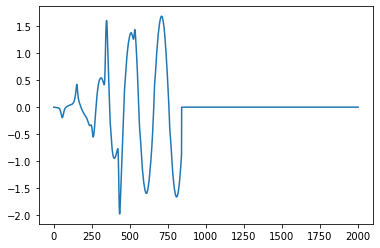

In [12]:
plt.plot(storeCurrent)

In [ ]:
plt.plot(ndensity[0,1:-1])


In [ ]:
plt.plot(ndensity[2,1:-1])
